In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt


In [2]:
df=pd.read_pickle('/home/bhatti/simulations/Wafer_data/LSWMD.pkl/LSWMD.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
df.tail(20)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811437,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,8.0,[[Test]],[[Edge-Ring]]
811438,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,9.0,[[Test]],[[none]]
811439,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,10.0,[[Test]],[[none]]
811440,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,11.0,[[Test]],[[Center]]
811441,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,12.0,[[Test]],[[Edge-Ring]]
811442,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",600.0,lot47542,13.0,[[Test]],[[none]]
811443,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,14.0,[[Test]],[[Edge-Loc]]
811444,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,15.0,[[Test]],[[Edge-Ring]]
811445,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,16.0,[[Test]],[[none]]
811446,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,17.0,[[Test]],[[Edge-Loc]]


In [4]:
df = df.drop(['waferIndex'], axis = 1)

In [5]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(50)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
332214,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2489.0,lot20048,[],[],"(59, 54)"
446820,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot27425,[],[],"(32, 29)"
175602,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3036.0,lot11233,[],[],"(63, 62)"
248448,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",741.0,lot15489,[[Training]],[[none]],"(31, 32)"
479178,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot29664,[],[],"(49, 39)"
667404,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",712.0,lot41557,[],[],"(32, 29)"
394575,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1226.0,lot23642,[[Training]],[[Donut]],"(40, 40)"
353706,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",13317.0,lot21122,[],[],"(123, 136)"
387280,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1334.0,lot23190,[],[],"(41, 42)"
340185,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3642.0,lot20426,[],[],"(64, 72)"


In [6]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
df

/home/bhatti/anaconda3/envs/tf_gpu_2/lib/python3.7/site-packages/pandas/core/array_algos/replace.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
...,...,...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Ring]],"(26, 30)",3,1
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Loc]],"(26, 30)",2,1
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Ring]],"(26, 30)",3,1
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,[],[],"(26, 30)",[],[]


In [7]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [8]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

/home/bhatti/anaconda3/envs/tf_gpu_2/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


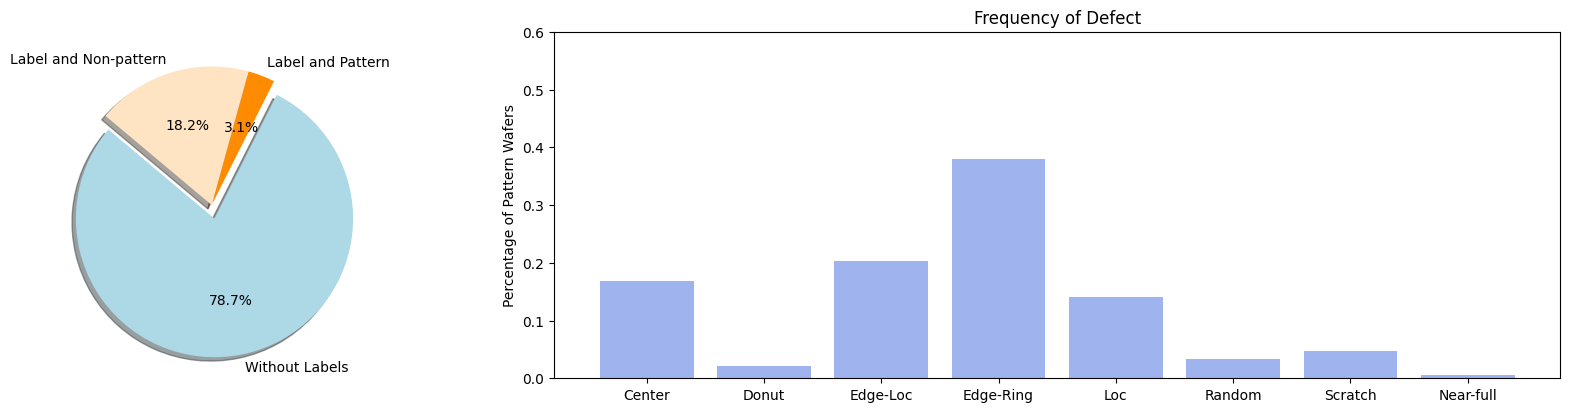

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['lightblue', 'darkorange', 'bisque']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['Without Labels','Label and Pattern','Label and Non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='royalblue', align='center', alpha=0.5)
ax2.set_title("Frequency of Defect")
ax2.set_ylabel("Percentage of Pattern Wafers")
ax2.set_xticklabels(labels2)
ax2.set_ylim([0,0.6])
plt.show()

/home/bhatti/anaconda3/envs/tf_gpu_2/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


Text(0.5, 1.0, 'Near-full')

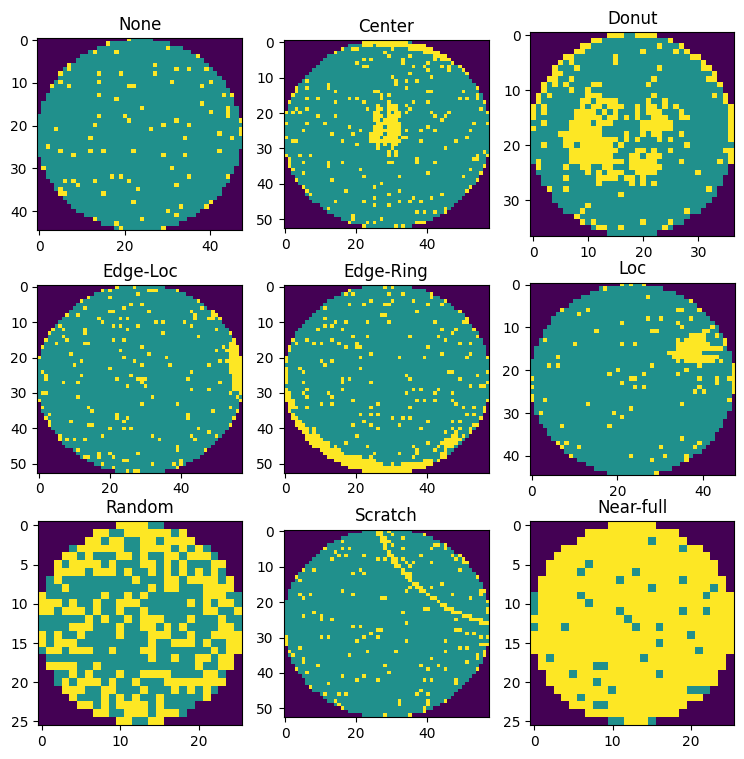

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes[0,0].imshow(df[df['failureType']=='none']['waferMap'].iloc[0])
axes[0,0].set_title('None')

axes[0,1].imshow(df[df['failureType']=='Center']['waferMap'].iloc[0])
axes[0,1].set_title('Center')

axes[0,2].imshow(df[df['failureType']=='Donut']['waferMap'].iloc[0])
axes[0,2].set_title('Donut')

axes[1,0].imshow(df[df['failureType']=='Edge-Loc']['waferMap'].iloc[0])
axes[1,0].set_title('Edge-Loc')


axes[1,1].imshow(df[df['failureType']=='Edge-Ring']['waferMap'].iloc[0])
axes[1,1].set_title('Edge-Ring')

axes[1,2].imshow(df[df['failureType']=='Loc']['waferMap'].iloc[0])
axes[1,2].set_title('Loc')

axes[2,0].imshow(df[df['failureType']=='Random']['waferMap'].iloc[0])
axes[2,0].set_title('Random')

axes[2,1].imshow(df[df['failureType']=='Scratch']['waferMap'].iloc[0])
axes[2,1].set_title('Scratch')

axes[2,2].imshow(df[df['failureType']=='Near-full']['waferMap'].iloc[0])
axes[2,2].set_title('Near-full')

In [11]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [12]:
x = sw[1:]
y = np.array(label).reshape((-1,1))
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))
x = x.reshape((-1, 26, 26, 1))

x shape : (14366, 26, 26), y shape : (14366, 1)


In [13]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))
# for f in faulty_case :
#     print('{} : {}'.format(f, len(y[y==f])))
    
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [14]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [15]:
epoch=50
batch_size=1024

# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/50
15/15 - 5s - loss: 0.1416 - 5s/epoch - 337ms/step
Epoch 2/50
15/15 - 0s - loss: 0.0913 - 200ms/epoch - 13ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0798 - 220ms/epoch - 15ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0691 - 179ms/epoch - 12ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0607 - 214ms/epoch - 14ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0542 - 194ms/epoch - 13ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0486 - 194ms/epoch - 13ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0434 - 199ms/epoch - 13ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0384 - 180ms/epoch - 12ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0339 - 191ms/epoch - 13ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0301 - 197ms/epoch - 13ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0269 - 204ms/epoch - 14ms/step
Epoch 13/50
15/15 - 0s - loss: 0.0244 - 198ms/epoch - 13ms/step
Epoch 14/50
15/15 - 0s - loss: 0.0223 - 207ms/epoch - 14ms/step
Epoch 15/50
15/15 - 0s - loss: 0.0205 - 186ms/epoch - 12ms/step
Epoch 16/50
15/15 - 0s - loss: 0.0189 - 212ms/epoch

In [16]:
encoder = models.Model(input_tensor, latent_vector)

decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

# check original faulty wafer data
#plt.imshow(np.argmax(new_x[3], axis=2))

# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
#plt.imshow(noised_gen_x[3])

449/449 [==============================] - 1s 2ms/step


In [17]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

3/3 [==============================] - 0s 2ms/step


In [18]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))
    
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

new_X=new_x[0:19000]
new_Y=new_y[0:19000]
test_x=new_x[19001:19706]
test_y=new_y[19001:19706]

x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.33,
                                                    random_state=2019)

print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489
After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)
Train x : (12730, 26, 26, 3), y : (12730, 9)
Test x: (6270, 26, 26, 3), y : (6270, 9)


In [19]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [20]:
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

/home/bhatti/anaconda3/envs/tf_gpu_2/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Epoch 1/50
9/9 - 3s - loss: 2.2113 - accuracy: 0.2858 - 3s/epoch - 342ms/step
Epoch 2/50
9/9 - 0s - loss: 1.0322 - accuracy: 0.6421 - 297ms/epoch - 33ms/step
Epoch 3/50
9/9 - 0s - loss: 0.6635 - accuracy: 0.7629 - 277ms/epoch - 31ms/step
Epoch 4/50
9/9 - 0s - loss: 0.4317 - accuracy: 0.8500 - 285ms/epoch - 32ms/step
Epoch 5/50
9/9 - 0s - loss: 0.2555 - accuracy: 0.9192 - 299ms/epoch - 33ms/step
Epoch 6/50
9/9 - 0s - loss: 0.2053 - accuracy: 0.9423 - 295ms/epoch - 33ms/step
Epoch 7/50
9/9 - 0s - loss: 0.4353 - accuracy: 0.9008 - 298ms/epoch - 33ms/step
Epoch 8/50
9/9 - 0s - loss: 0.3147 - accuracy: 0.8790 - 287ms/epoch - 32ms/step
Epoch 9/50
9/9 - 0s - loss: 0.1550 - accuracy: 0.9694 - 273ms/epoch - 30ms/step
Epoch 10/50
9/9 - 0s - loss: 0.0857 - accuracy: 0.9807 - 271ms/epoch - 30ms/step
Epoch 11/50
9/9 - 0s - loss: 0.0464 - accuracy: 0.9915 - 285ms/epoch - 32ms/step
Epoch 12/50
9/9 - 0s - loss: 0.0298 - accuracy: 0.9949 - 280ms/epoch - 31ms/step
Epoch 13/50
9/9 - 0s - loss: 0.0204 - a

In [21]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=50,
         batch_size=batch_size,
         )

score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)



Epoch 1/50
13/13 - 3s - loss: 1.7170 - accuracy: 0.4132 - val_loss: 0.7686 - val_accuracy: 0.6909 - 3s/epoch - 245ms/step
Epoch 2/50
13/13 - 1s - loss: 0.5954 - accuracy: 0.7747 - val_loss: 0.4078 - val_accuracy: 0.8483 - 504ms/epoch - 39ms/step
Epoch 3/50
13/13 - 1s - loss: 0.3253 - accuracy: 0.8929 - val_loss: 0.2177 - val_accuracy: 0.9305 - 508ms/epoch - 39ms/step
Epoch 4/50
13/13 - 1s - loss: 0.1579 - accuracy: 0.9529 - val_loss: 0.1227 - val_accuracy: 0.9676 - 520ms/epoch - 40ms/step
Epoch 5/50
13/13 - 1s - loss: 0.0729 - accuracy: 0.9830 - val_loss: 0.0615 - val_accuracy: 0.9817 - 620ms/epoch - 48ms/step
Epoch 6/50
13/13 - 1s - loss: 0.0296 - accuracy: 0.9951 - val_loss: 0.0318 - val_accuracy: 0.9922 - 662ms/epoch - 51ms/step
Epoch 7/50
13/13 - 1s - loss: 0.0154 - accuracy: 0.9974 - val_loss: 0.0193 - val_accuracy: 0.9959 - 635ms/epoch - 49ms/step
Epoch 8/50
13/13 - 1s - loss: 0.0116 - accuracy: 0.9984 - val_loss: 0.0255 - val_accuracy: 0.9949 - 646ms/epoch - 50ms/step
Epoch 9/50

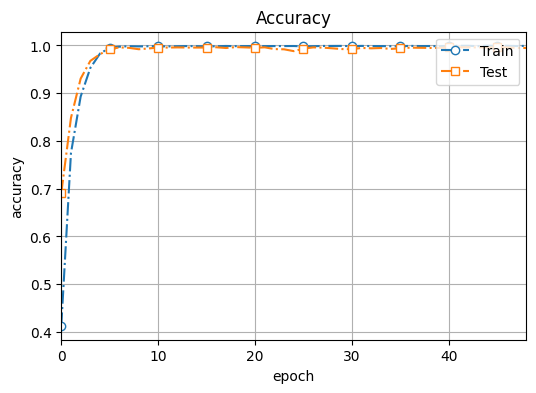

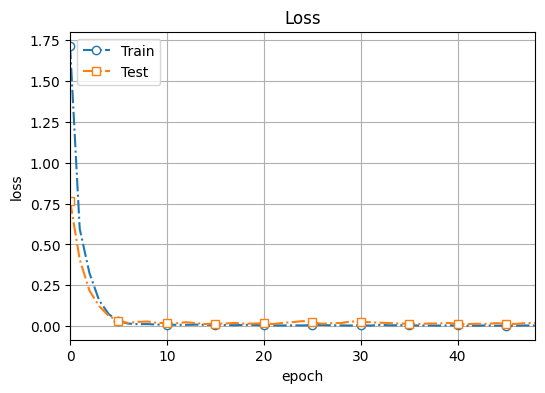

In [22]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'],'-.o',markevery=5,markerfacecolor='w')
plt.plot(history.history['val_accuracy'],'-.s',markevery=5,markerfacecolor='w')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid()
plt.xlim([0,48])
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],'-.o',markevery=5,markerfacecolor='w')
plt.plot(history.history['val_loss'],'-.s',markevery=5,markerfacecolor='w')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.xlim([0,48])
plt.show()